<a href="https://colab.research.google.com/github/Bushman57/Food-Vision101/blob/main/Weights_and_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🛣️For this colab we aim to explore varous Image classification problems:

*  Categorical output data
*  Binary output data

With the core idea of learning how to keep track of models during creating as well as transfer learning and running models.

In [ ]:
## Categorical data output

## Introduction to Weights and biases

Use Weight and biases for machine learning experiment tracking, dataset versioning, and project collaboration

In [ ]:
# Downgrade tensorflow and tensor_hub versions
!pip install tensorflow==2.8.0 tensorflow_hub==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow_hub
    Found existing installation: tensorflow-hub 0.16.1
    Uninstalling tensorflow-hub-0.16.1:
      Successfully uninstalled tensorflow-hub-0.16.1
  Attempting uninstall: tensorboar

In [ ]:
# Modules

import os
import random

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
from tensorflow import keras


# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC']='1'
random.seed(hash('setting random seeds')% 2**32 -1)
np.random.seed(hash('ïmproves reproducibility')% 2**32 -1)
tf.random.set_seed(hash('by removing stochasticity')% 2**32 -1)

### Step 0: Install W&B

In [ ]:
%%capture
!pip install wandb

### Step 1: Import W&B and Login


In [ ]:
# Weights and Biases related imports
import wandb
from wandb.integration.keras import WandbMetricsLogger

In [ ]:
# First timers only
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## HyperParameters

Use of proper config system is a recommended best practise for reproducible machine learning.We can track the hyperparameters for every experiment using W&B. IN this colab we will be using simple Python `dict` as our config system.


In [ ]:
configs = dict(
    num_classes = 10, #Can be changed to suite the model output
    shuffle_buffer = 1024,
    batch_size = 32,
    image_size = 224,
    image_channels = 3,
    earlystopping_patience = 3,
    learning_rate = 1e-3,
    epochs = 5
)

## 🍁 Dataset

In this colab we will be using `10_classes_Food101` from the [Transfer learning module](https://colab.research.google.com/drive/1CPSKtCoUTskWF_laE1ZIJNZYKjwjF_Fy#scrollTo=MgLNGJ2DFR5B)

We aim to build an image classification using pretrained model for 10 different dishes using Tensorflow/Keras

We will also use kaggle models to be used as the models:
1. ResNetv2_50
2. EfficientNetB7

🥲😥 Encountered issue with using hub to load model future me, let me know if you find out🛣️

In [ ]:
# Get the data (10% of 10 food classes from Food101)

import zipfile

# Download the data
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded data
zip_ref =zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-08-08 08:35:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   219MB/s    in 0.7s    

2024-08-08 08:35:36 (219 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Setup the data Inputs

In [ ]:
# Module
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Data augmentation
IMAGE_SHAPE=(224,224)
BATCH_SIZE =32
EPOCHS =5

train_dir = '10_food_classes_10_percent/train'
test_dir ='10_food_classes_10_percent/test'

train_datagen =ImageDataGenerator(rescale =1/255.,
                                  zoom_range =0.3,
                                  horizontal_flip =True
                                  )
test_datagen =ImageDataGenerator(rescale =1/255.)

print("Training images")
train_data =train_datagen.flow_from_directory(train_dir,
                                              target_size =IMAGE_SHAPE,
                                              batch_size =configs["batch_size"],
                                              class_mode ='categorical')
print("Testing images")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size =IMAGE_SHAPE,
                                           batch_size =configs["batch_size"],
                                           class_mode ='categorical')



Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## 🤖 Loading Model using kaggle

For the model section we will rely on kaggle which was merged with tensorflow hub to be able to access `efficientB7` and `ResNetv2_50` models.
Main Aim here is to familiriaze with examples of transfer learning methods.
For this section we will use `Feature Extraction` as our transfer learning method.


In [ ]:

# Link the json file
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
#Module

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras import Sequential,layers

In [ ]:
#  Let's make a create_model()  function to create a model from a url

def create_model(model_url,configs,num_classes=10):
  """
  Takes a kaggle URL and create a keras Sequential model with it

  Args:
  model_url (str): A kaggle URL feature extraction
  num_classes (int): Number of output neurons in the output layer,
  should be equal to Number of target classes, default 10.

  Returns:
  A compiled Keras Sequential model with model_url as feature extractor
  layer and Dense output neurons

  The compiler uses Adam optimizer with accuracy as the metric
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer =hub.KerasLayer(model_url,
                                           trainable= False, # Freeze the already learned patterns
                                           #name = "feature_extraction_layer",
                                           input_shape =(configs["image_size"],configs["image_size"],configs["image_channels"]))

  # Create our own model
  model =tf.keras.Sequential([
      feature_extraction_layer,
      tf.keras.layers.Dense(configs["num_classes"],activation ='softmax', name ='output_layer')
  ])


  # model =tf.keras.Sequential()
  # model.add(feature_extraction_layer)
  # model.add(layers.Dense(num_classes,activation ='softmax', name ='output_layer'))
  #     feature_extraction_layer,
  #     tf.keras.layers.Dense(num_classes,activation ='softmax', name ='output_layer')
  # ])


  return model

In [ ]:
tf.__version__,hub.__version__
 # Make sure they meet this versions  TensorFlow 2 (or 1.15) and TensorFlow Hub 0.5.0 or newer.

('2.8.0', '0.12.0')

In [ ]:
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-ft1k-b3-feature-vector/1"

In [ ]:
# Create the resnet model
resnet_model =create_model(resnet_url,configs=configs,num_classes =10)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# Compile model
resnet_model.compile(optimizer =tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics =["accuracy"])


In [ ]:
run =wandb.init(
    project = "Compairing ResNet and EfficientNet",
    config = configs
)

# Fit the resnet model
resnet_history =resnet_model.fit(train_data,
                              epochs =configs["epochs"],
                              steps_per_epoch =len(train_data),
                              validation_data =test_data,
                              validation_steps =len(test_data),
                              callbacks = [WandbMetricsLogger(log_freq=10)])

run.finish()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/5
24/24 [==============================] - 610s 26s/step - loss: 1.9245 - accuracy: 0.3480 - val_loss: 1.0179 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 595s 26s/step - loss: 0.9497 - accuracy: 0.7187 - val_loss: 0.7298 - val_accuracy: 0.7756
Epoch 3/5
24/24 [==============================] - 599s 26s/step - loss: 0.6879 - accuracy: 0.7987 - val_loss: 0.6058 - val_accuracy: 0.8100
Epoch 4/5
24/24 [==============================] - 621s 27s/step - loss: 0.5460 - accuracy: 0.8480 - val_loss: 0.5567 - val_accuracy: 0.8312
Epoch 5/5
24/24 [==============================] - 598s 26s/step - loss: 0.4734 - accuracy: 0.8693 - val_loss: 0.5630 - val_accuracy: 0.8204


In [ ]:
# Create efficient model
efficient_model =create_model(efficientnet_url,configs=configs,num_classes =10)
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              12930622  
                                                                 
 output_layer (Dense)        (None, 10)                15370     
                                                                 
Total params: 12,945,992
Trainable params: 15,370
Non-trainable params: 12,930,622
_________________________________________________________________


In [ ]:
# Compile model
efficient_model.compile(optimizer =tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics =["accuracy"])

In [ ]:
# Fit the model
run =wandb.init(
    project = "Compairing ResNet and EfficientNet",
    config = configs
)

# Fit the resnet model
efficient_history =efficient_model.fit(train_data,
                              epochs =configs["epochs"],
                              steps_per_epoch =len(train_data),
                              validation_data =test_data,
                              validation_steps =len(test_data),
                              callbacks = [WandbMetricsLogger(log_freq=10)])

run.finish()


Epoch 1/5
24/24 [==============================] - 51s 2s/step - loss: 2.0516 - accuracy: 0.3533 - val_loss: 0.8457 - val_accuracy: 0.7552
Epoch 2/5
24/24 [==============================] - 34s 1s/step - loss: 0.7885 - accuracy: 0.7573 - val_loss: 0.4842 - val_accuracy: 0.8512
Epoch 3/5
24/24 [==============================] - 35s 1s/step - loss: 0.4966 - accuracy: 0.8440 - val_loss: 0.3799 - val_accuracy: 0.8868
Epoch 4/5
24/24 [==============================] - 35s 1s/step - loss: 0.3922 - accuracy: 0.8840 - val_loss: 0.3497 - val_accuracy: 0.8952
Epoch 5/5
24/24 [==============================] - 35s 1s/step - loss: 0.3230 - accuracy: 0.9053 - val_loss: 0.3165 - val_accuracy: 0.9044


## Binary output data

We will use a dummy data, where we are going to try and different dishes of ugali and pilau😋.[Data](https://drive.google.com/drive/folders/1PTJ5qKaTJEz63jTDqlqoaTmH7nDqJZMN?usp=sharing)


In [ ]:
# Mount drive


In [ ]:
## Debugging(Make sure you see the binary data)
!ls /content/drive/MyDrive/dishes

test  train


In [ ]:
# copy the images from to colab directory
!cp -r /content/drive/MyDrive/dishes /content

### Get to be one with the data🧘🏿‍♂️👴🏿

Takeaway tips:

- Visualize some sample of your data to check for irregularities that could hinder the model performance
as well as familiarizing with the data


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
## let's create a function to load in the data and plot three_images

def plot_three_images(target_dir,target_class):
  """
  Randomly selects and displays 3 random images
  from `target_class` folder in `target_dir` folder.

  eg. target_dir = '/content/Dish/dishes/' ,target_class = 'pilau'
  Requires target_dir to be in format:
      target_dir
                |target_class_1
                |target_class_2
                |...
  """
  target_path =target_dir + target_class
  file_names =os.listdir(target_path)
  target_images= random.sample(file_names,3)

  # Plot images
  plt.figure(figsize=(15,6))
  for i, img in enumerate(target_images):
    img_path =target_path + "/" + img
    plt.subplot(1,3,i+1)
    plt.imshow(mpimg.imread(img_path))
    plt.title(target_class)
    plt.axis("off");

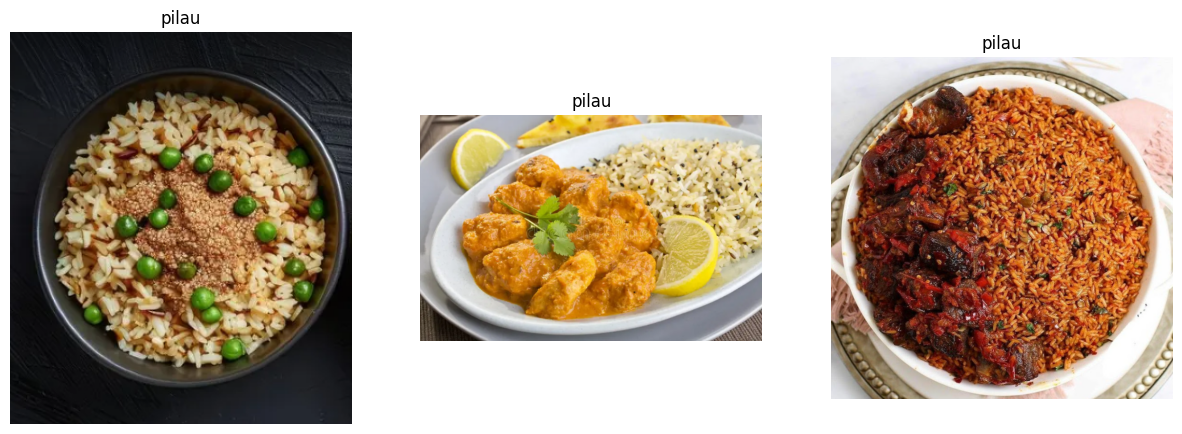

In [ ]:
# Inspect the pilau data
plot_three_images(target_dir="/content/dishes/train/",
                  target_class ="pilau")

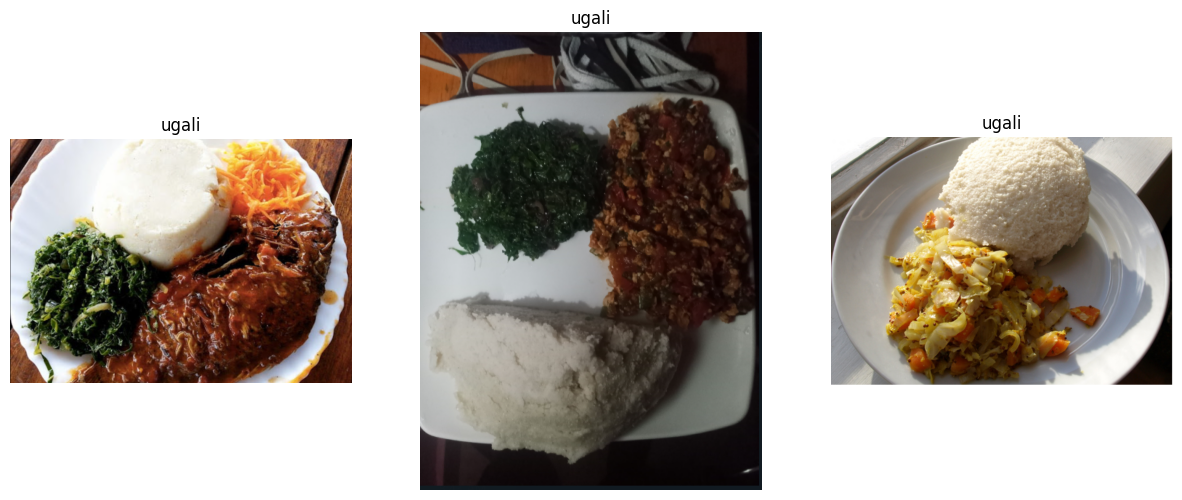

In [ ]:
# Inspect the ugali data
plot_three_images(target_dir="/content/dishes/train/",
                  target_class="ugali")

### Data Preparation👨🏿‍🍳

In [ ]:
configs =dict(
    batch_size =3,
    image_size =224,
    image_channels =3,
    epochs =10,
    learning_rate =1e-3,
    earlystopping_patience = 3,
    set_seed =42,
    num_classes =1
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'dishes/train'
test_dir = 'dishes/test'

train_datagen =ImageDataGenerator(rescale =1/255.,
                                  zoom_range =0.2,
                                  horizontal_flip =True)

test_datagen = ImageDataGenerator(rescale =1/255.)

print("Training images")
train_diata =train_datagen.flow_from_directory(train_dir,
                                               target_size = (configs["image_size"],configs["image_size"]),
                                               batch_size =configs['batch_size'],
                                               class_mode ='binary')

print("Test images")
test_diata =test_datagen.flow_from_directory(test_dir,
                                             target_size =(configs["image_size"],configs["image_size"]),
                                             batch_size =configs["batch_size"],
                                             class_mode = 'binary')

Training images
Found 30 images belonging to 2 classes.
Test images
Found 10 images belonging to 2 classes.


### Import the kaggle models we will use for classisfying the images

We are going to import the following models to use transfer learning on our data :
* ResNet
* EfficientNet
* MobileNetV2


In [ ]:
# Download url for the models
Binary_ResNet_url ="https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"
Binary_EffNet_url ="https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-ft1k-b3-feature-vector/1"
Binary_MobileNet_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/140-224-feature-vector/2"

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf


In [ ]:
## Update the create model to adjust for binary data

#  Let's make a create_model()  function to create a model from a url

def create_model(model_url,configs,num_classes=10):
  """
  Takes a kaggle URL and create a keras Sequential model with it

  Args:
  model_url (str): A kaggle URL feature extraction
  num_classes (int): Number of output neurons in the output layer,
  should be equal to Number of target classes, default 10.

  Returns:
  A compiled Keras Sequential model with model_url as feature extractor
  layer and Dense output neurons

  The compiler uses Adam optimizer with accuracy as the metric
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer =hub.KerasLayer(model_url,
                                           trainable= False, # Freeze the already learned patterns
                                           #name = "feature_extraction_layer",
                                           input_shape =(configs["image_size"],configs["image_size"],configs["image_channels"]))

  # Create our own model
  model =tf.keras.Sequential([
      feature_extraction_layer,
      tf.keras.layers.Dense(configs["num_classes"],activation ='sigmoid', name ='output_layer')
  ])


  # Compile model
  model.compile(optimizer =tf.keras.optimizers.Adam(),
                        loss = 'binary_crossentropy',
                        metrics =['accuracy'])


  return model

In [ ]:
# create ResNet model
Bi_resNet_model =create_model(Binary_ResNet_url,configs=configs)

# Summary
Bi_resNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# Fit the model
run =wandb.init(
    project = "Binary Classification with Feature extraction",
    config = configs
)

Bi_resNet_model.fit(train_diata,
                    validation_data =test_diata,
                    epochs = configs["epochs"],
                    callbacks = [WandbMetricsLogger(log_freq =10)])
run.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/10
10/10 [==============================] - 14s 747ms/step - loss: 0.4991 - accuracy: 0.7667 - val_loss: 0.4427 - val_accuracy: 0.9000
Epoch 2/10
10/10 [==============================] - 8s 829ms/step - loss: 0.3093 - accuracy: 0.9000 - val_loss: 0.3148 - val_accuracy: 0.9000
Epoch 3/10
10/10 [==============================] - 6s 619ms/step - loss: 0.1773 - accuracy: 1.0000 - val_loss: 0.2840 - val_accuracy: 0.9000
Epoch 4/10
10/10 [==============================] - 8s 800ms/step - loss: 0.1143 - accuracy: 1.0000 - val_loss: 0.3039 - val_accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 6s 608ms/step - loss: 0.0781 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.8000
Epoch 6/10
10/10 [==============================] - 8s 827ms/step - loss: 0.0632 - accuracy: 1.0000 - val_loss: 0.2871 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 6s 611ms/step - loss: 0.0666 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.8000
Epoch

In [ ]:
#  create an EfficientNet model

Bi_effNet_model =create_model(Binary_EffNet_url,configs=configs)

# Summary
Bi_effNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              12930622  
                                                                 
 output_layer (Dense)        (None, 1)                 1537      
                                                                 
Total params: 12,932,159
Trainable params: 1,537
Non-trainable params: 12,930,622
_________________________________________________________________


In [ ]:
# Fit the model
run =wandb.init(
    project = "Binary Classification with Feature extraction",
    config = configs
)

Bi_effNet_model.fit(train_diata,
                    validation_data =test_diata,
                    epochs = configs["epochs"],
                    callbacks = [WandbMetricsLogger(log_freq =10)])
run.finish()

wandb: Currently logged in as: savins (bushman254). Use `wandb login --relogin` to force relogin


Epoch 1/10
10/10 [==============================] - 15s 579ms/step - loss: 0.5335 - accuracy: 0.7667 - val_loss: 0.4385 - val_accuracy: 0.8000
Epoch 2/10
10/10 [==============================] - 4s 394ms/step - loss: 0.2748 - accuracy: 0.9333 - val_loss: 0.3107 - val_accuracy: 0.8000
Epoch 3/10
10/10 [==============================] - 6s 550ms/step - loss: 0.1455 - accuracy: 1.0000 - val_loss: 0.3200 - val_accuracy: 0.8000
Epoch 4/10
10/10 [==============================] - 4s 374ms/step - loss: 0.0886 - accuracy: 1.0000 - val_loss: 0.2548 - val_accuracy: 0.9000
Epoch 5/10
10/10 [==============================] - 4s 377ms/step - loss: 0.0623 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 0.9000
Epoch 6/10
10/10 [==============================] - 6s 585ms/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.2638 - val_accuracy: 0.9000
Epoch 7/10
10/10 [==============================] - 4s 393ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9000
Epoch

In [ ]:
# Create a MobileNetV2 model
Bi_MobileNet_model =create_model(Binary_MobileNet_url,configs=configs)

# Summary
Bi_MobileNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 output_layer (Dense)        (None, 1)                 1793      
                                                                 
Total params: 4,365,505
Trainable params: 1,793
Non-trainable params: 4,363,712
_________________________________________________________________


In [ ]:
#!wandb login --relogin
# Fit the model
run =wandb.init(
    project = "Binary Classification with Feature extraction",
    config = configs
)

Bi_MobileNet_model.fit(train_diata,
                    validation_data =test_diata,
                    epochs = configs["epochs"],
                    callbacks = [WandbMetricsLogger(log_freq =10)])
run.finish()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


Epoch 1/10
10/10 [==============================] - 8s 384ms/step - loss: 0.5877 - accuracy: 0.6333 - val_loss: 0.6151 - val_accuracy: 0.7000
Epoch 2/10
10/10 [==============================] - 2s 213ms/step - loss: 0.3232 - accuracy: 0.9333 - val_loss: 0.3900 - val_accuracy: 0.9000
Epoch 3/10
10/10 [==============================] - 2s 218ms/step - loss: 0.1819 - accuracy: 1.0000 - val_loss: 0.3806 - val_accuracy: 0.9000
Epoch 4/10
10/10 [==============================] - 2s 209ms/step - loss: 0.1465 - accuracy: 0.9667 - val_loss: 0.3624 - val_accuracy: 0.9000
Epoch 5/10
10/10 [==============================] - 2s 211ms/step - loss: 0.1017 - accuracy: 1.0000 - val_loss: 0.3107 - val_accuracy: 0.9000
Epoch 6/10
10/10 [==============================] - 4s 357ms/step - loss: 0.0812 - accuracy: 1.0000 - val_loss: 0.3316 - val_accuracy: 0.9000
Epoch 7/10
10/10 [==============================] - 2s 214ms/step - loss: 0.0640 - accuracy: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9000
Epoch 

In [ ]:
def Prep_load(filename):
  """
  Takes an image file path and turns it into a tensor
  """
  img =tf.io.read_file(filename) # Read image
  img =tf.image.decode_image(img) # Decode the read file into a tensor
  img =tf.image.resize(img,size =[configs["image_size"],configs['image_size']]) # Resize image
  img =img/255. # Rescale image
  #Drop the alpha channel
  # img =img[:, :, 1:] #Keep only the first 3 channels (RGB)
  # img =img/255. # Rescale image
  return img

In [ ]:
def Prob_pred(y_prob,class_names):
  '''
  Takes in the probability for the predicted labels
  '''
  y_pred=tf.round(y_prob)
  pred_class =class_names[int(y_pred)]
  #Return pred_classes
  return pred_class

In [ ]:
## Create a function to plot the prediction
def Pred_and_plot(model,filename,class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class
  """
  img =Prep_load(filename)
  # Make prediction
  pred =model.predict(tf.expand_dims(img,axis =0)) # Make prediction on image
  # Get the prediction
  pred_class =Prob_pred(pred,class_names)
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis("off");

In [ ]:
class_name =["pilau","ugali"]

In [ ]:
#

!wget "https://raw.githubusercontent.com/Bushman57/colab-/main/Screenshot%202024-08-09%20152313.jpg"

ugali =mpimg.imread("/content/Screenshot 2024-08-09 152313.jpg")

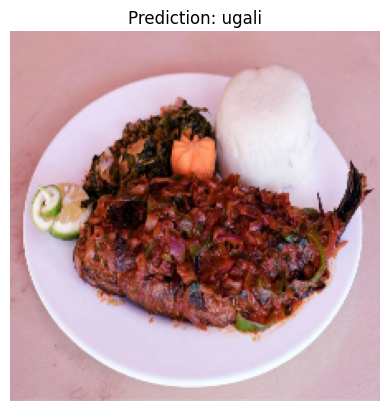

In [ ]:
Pred_and_plot(Bi_resNet_model,"/content/Screenshot 2024-08-09 152313.jpg",class_name)

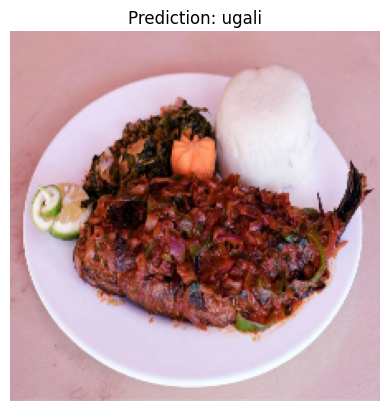

In [ ]:
Pred_and_plot(Bi_MobileNet_model,"/content/Screenshot 2024-08-09 152313.jpg",class_name)

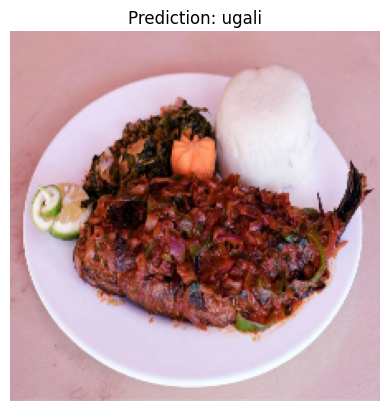

In [ ]:
Pred_and_plot(Bi_effNet_model,"/content/Screenshot 2024-08-09 152313.jpg",class_name)

In [ ]:
# MobileVnet
! wget  "https://raw.githubusercontent.com/Bushman57/colab-/main/vegan-curry-with-chickpeas-vegetables.jpg"


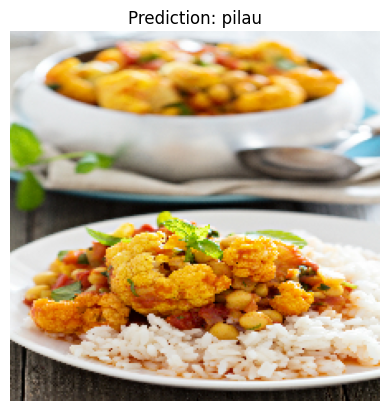

In [ ]:
Pred_and_plot(Bi_MobileNet_model,"/content/vegan-curry-with-chickpeas-vegetables.jpg",class_name)

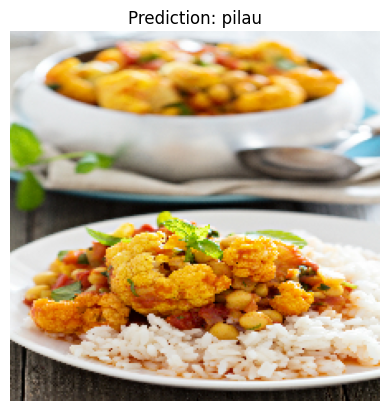

In [ ]:
Pred_and_plot(Bi_effNet_model,"/content/vegan-curry-with-chickpeas-vegetables.jpg",class_name)

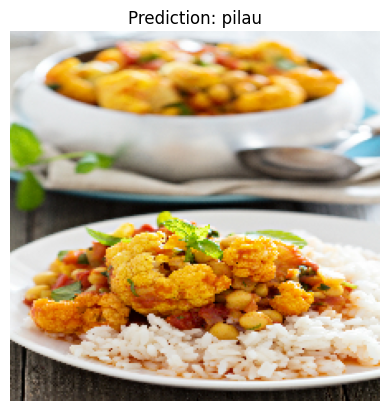

In [ ]:
Pred_and_plot(Bi_resNet_model,"/content/vegan-curry-with-chickpeas-vegetables.jpg",class_name)

In [ ]:
! wget "https://raw.githubusercontent.com/Bushman57/colab-/main/Screenshot%202024-08-09%20141114.jpeg"

ugali =mpimg.imread("/content/Screenshot 2024-08-09 141114.jpeg")


--2024-08-09 12:56:36--  https://raw.githubusercontent.com/Bushman57/colab-/main/Screenshot%202024-08-09%20141114.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106422 (104K) [image/jpeg]
Saving to: ‘Screenshot 2024-08-09 141114.jpeg’

Screenshot 2024-08- 100%[===================>] 103.93K  --.-KB/s    in 0.02s   

2024-08-09 12:56:36 (6.40 MB/s) - ‘Screenshot 2024-08-09 141114.jpeg’ saved [106422/106422]



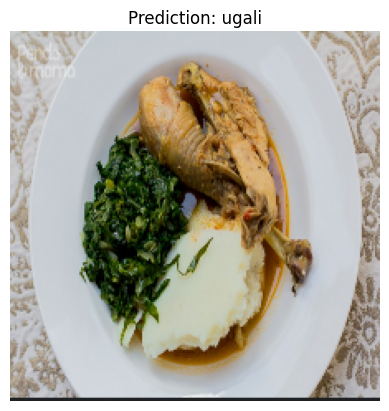

In [ ]:
Pred_and_plot(Bi_resNet_model,"/content/Screenshot 2024-08-09 141114.jpeg",class_name)

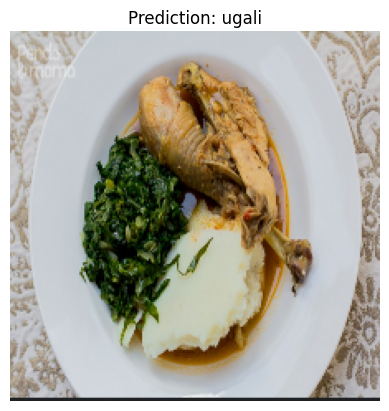

In [ ]:
Pred_and_plot(Bi_effNet_model,"/content/Screenshot 2024-08-09 141114.jpeg",class_name)

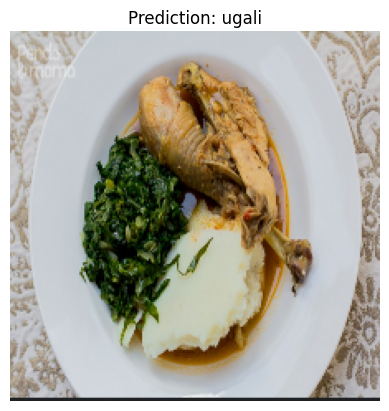

In [ ]:
Pred_and_plot(Bi_MobileNet_model,"/content/Screenshot 2024-08-09 141114.jpeg",class_name)

### Conclusion

The results are 🤯mind blowing even with such a small dataset although the classes were few the models demonstrated amazing results with accuracy close to 90% +

**Assignment** Future me try it on the bar drinks dataset